In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', size=6)

plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [3]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Cu_2p' : 5.321, 'Cl_2p' : 0.891})

## Pre-processing of data FBI on quartz window policrystal
1- Sublimations in UHV (15th Oct 2020)

## Import data

In [4]:
path = '/Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)

files = files_new
for f in files:
    print(f)

/Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_15_qITO/20210415_1-qITO_FBI_subl_60min.xy
/Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_15_qITO/20210415_1-qITO_as_received.xy
/Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_15_qITO/20210415_1-qITO_clean.xy


In [5]:
experiments = [xps_data_import(path=f) for f in files]
experiments[2].name

'1-qITO_clean'

# Align spectra

In [6]:
shift = find_shift(experiments[2], experiments[0], region='O1s')
shift

0.10000000000002274

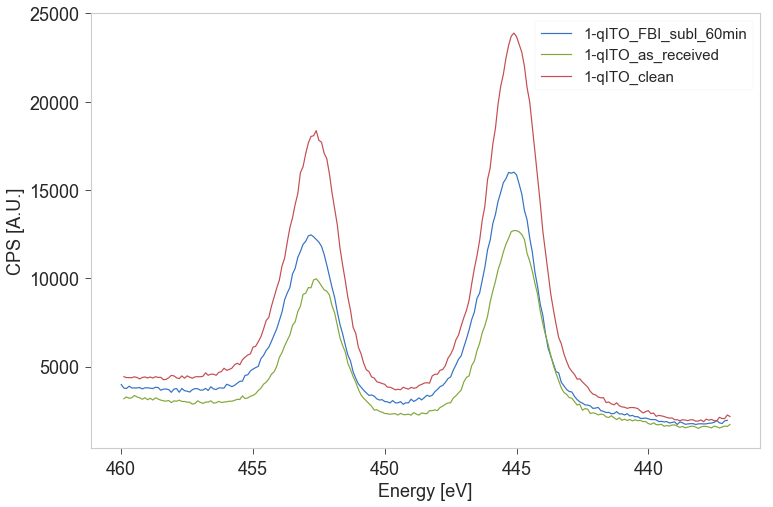

In [8]:
plt.figure(figsize=(12, 8))
for xp in experiments:
    shift = find_shift(xp, experiments[0], region='In3d')
    align_dfx(xp, shift, inplace=True)
    plot_region(xp, 'In3d')

# BG subtraction

## Bulk subtract background

In [11]:
experiments[0].dfx

C1s              In3d             N1s               O1s            \
     energy     counts energy   counts energy     counts energy    counts   
0     295.0  1235.5000  460.0  3985.00  405.0  1302.5625  538.0  4692.500   
1     294.9  1234.5625  459.9  3785.00  404.9  1307.1563  537.9  4608.125   
2     294.8  1241.3125  459.8  3763.75  404.8  1305.8125  537.8  4665.000   
3     294.7  1227.1875  459.7  3891.25  404.7  1325.4375  537.7  4761.875   
4     294.6  1228.8125  459.6  3791.25  404.6  1309.7188  537.6  4721.875   
...     ...        ...    ...      ...    ...        ...    ...       ...   
1200    NaN        NaN    NaN      NaN    NaN        NaN    NaN       NaN   
1201    NaN        NaN    NaN      NaN    NaN        NaN    NaN       NaN   
1202    NaN        NaN    NaN      NaN    NaN        NaN    NaN       NaN   
1203    NaN        NaN    NaN      NaN    NaN        NaN    NaN       NaN   
1204    NaN        NaN    NaN      NaN    NaN        NaN    NaN       NaN   

       Si2p             Sn3d               overview           
     energy    counts energy   counts        energy   counts  
0     110.0  1154.375  503.0  4582.50  1.200000e+03  11845.0  
1     109.9  1122.500  502.9  4446.25  1.199000e+03  12450.0  
2     109.8  1173.125  502.8  4508.75  1.198000e+03  12180.0  
3     109.7  1156.250  502.7  4416.25  1.197000e+03  11835.0  
4     109.6  1172.500  502.6  4501.25  1.196000e+03  12350.0  
...     ...       ...    ...      ...           ...      ...  
1200    NaN       NaN    NaN      NaN -2.273737e-13    575.0  
1201    NaN       NaN    NaN      NaN -1.000000e+00    705.0  
1202    NaN       NaN    NaN      NaN -2.000000e+00    825.0  
1203    NaN       NaN    NaN      NaN -3.000000e+00    710.0  
1204    NaN       NaN    NaN      NaN -4.000000e+00    775.0  

[1205 rows x 14 columns]

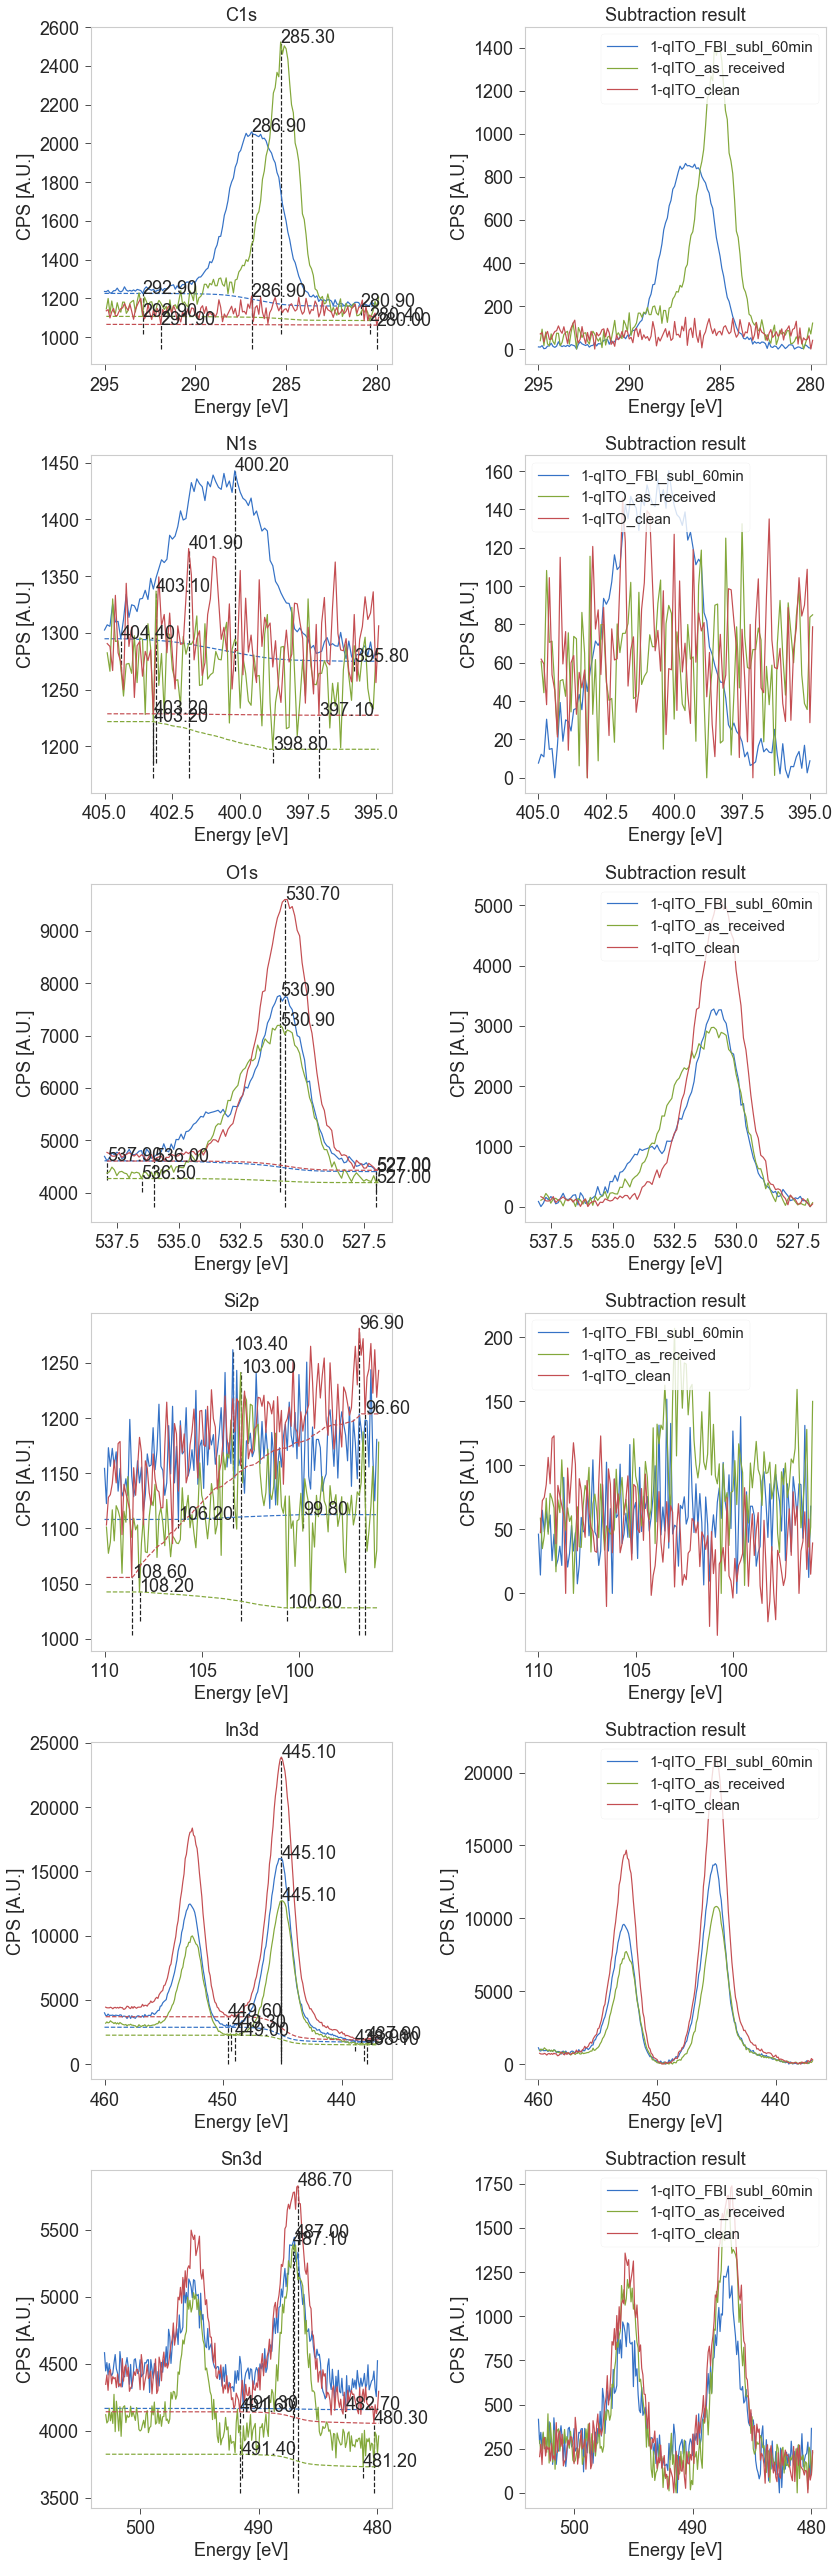

In [12]:
regions = ['C1s', 'N1s', 'O1s', 'Si2p']
bg_exps = bulk_bg_subtract(experiments, regions)

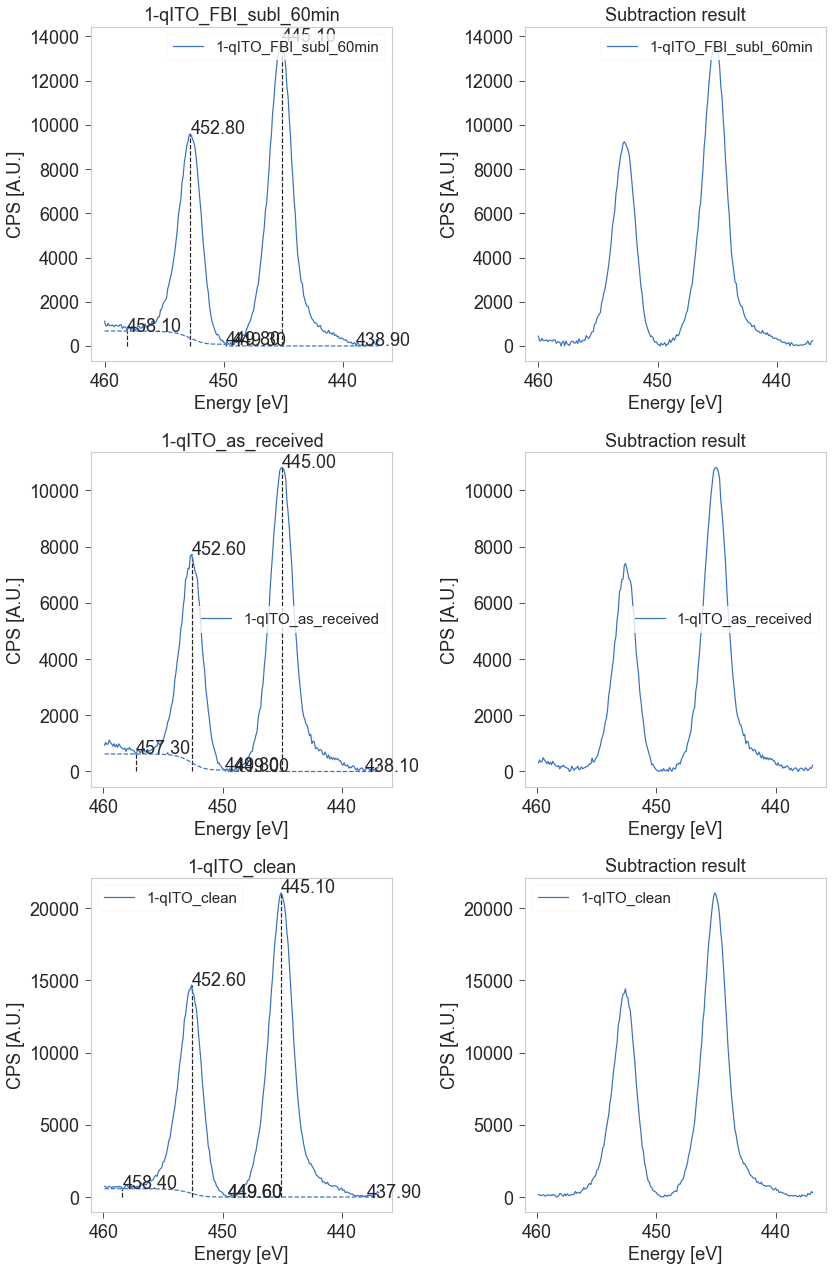

In [14]:
bg_exps = region_2bg_subtract(bg_exps, 'In3d', 449.60)

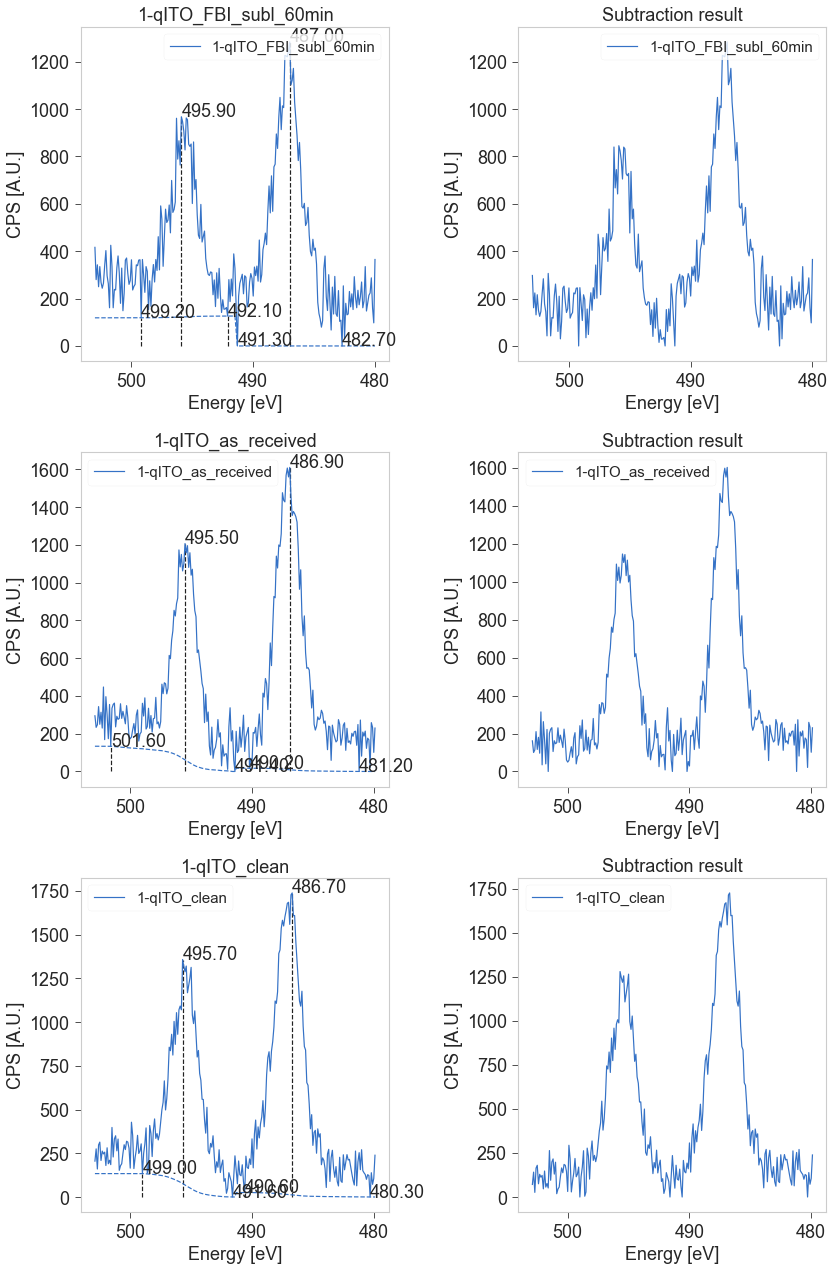

In [15]:
bg_exps = region_2bg_subtract(bg_exps, 'Sn3d', 491.40)

## Compress noisy N 1s 

In [26]:
bg_exps[0].name

'1-qITO_FBI_subl_60min'

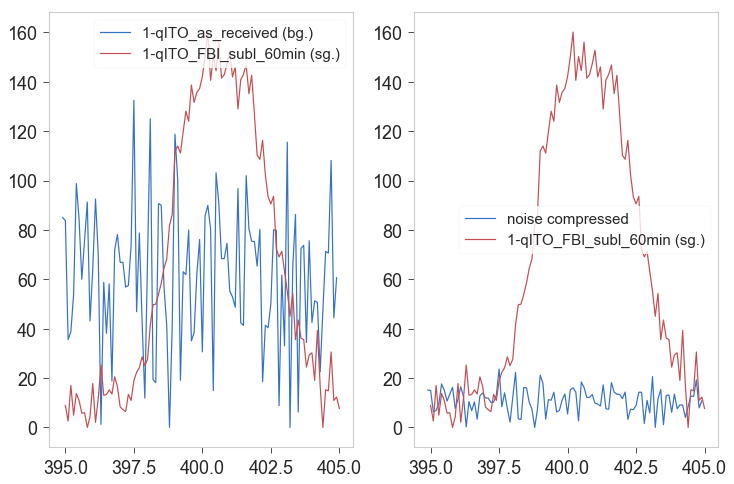

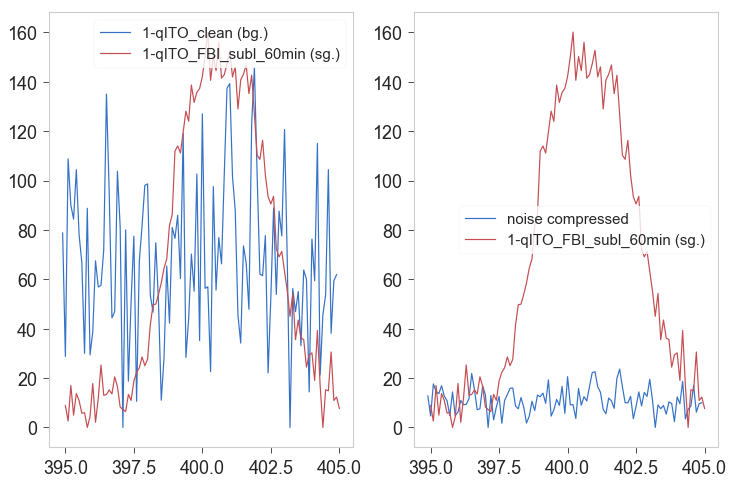

In [27]:
for xp in bg_exps:
    if 'FBI' not in xp.name:
        compress_noisy_region(xp=xp, xpRef=bg_exps[0], region='N1s')

# Scale to In 3d

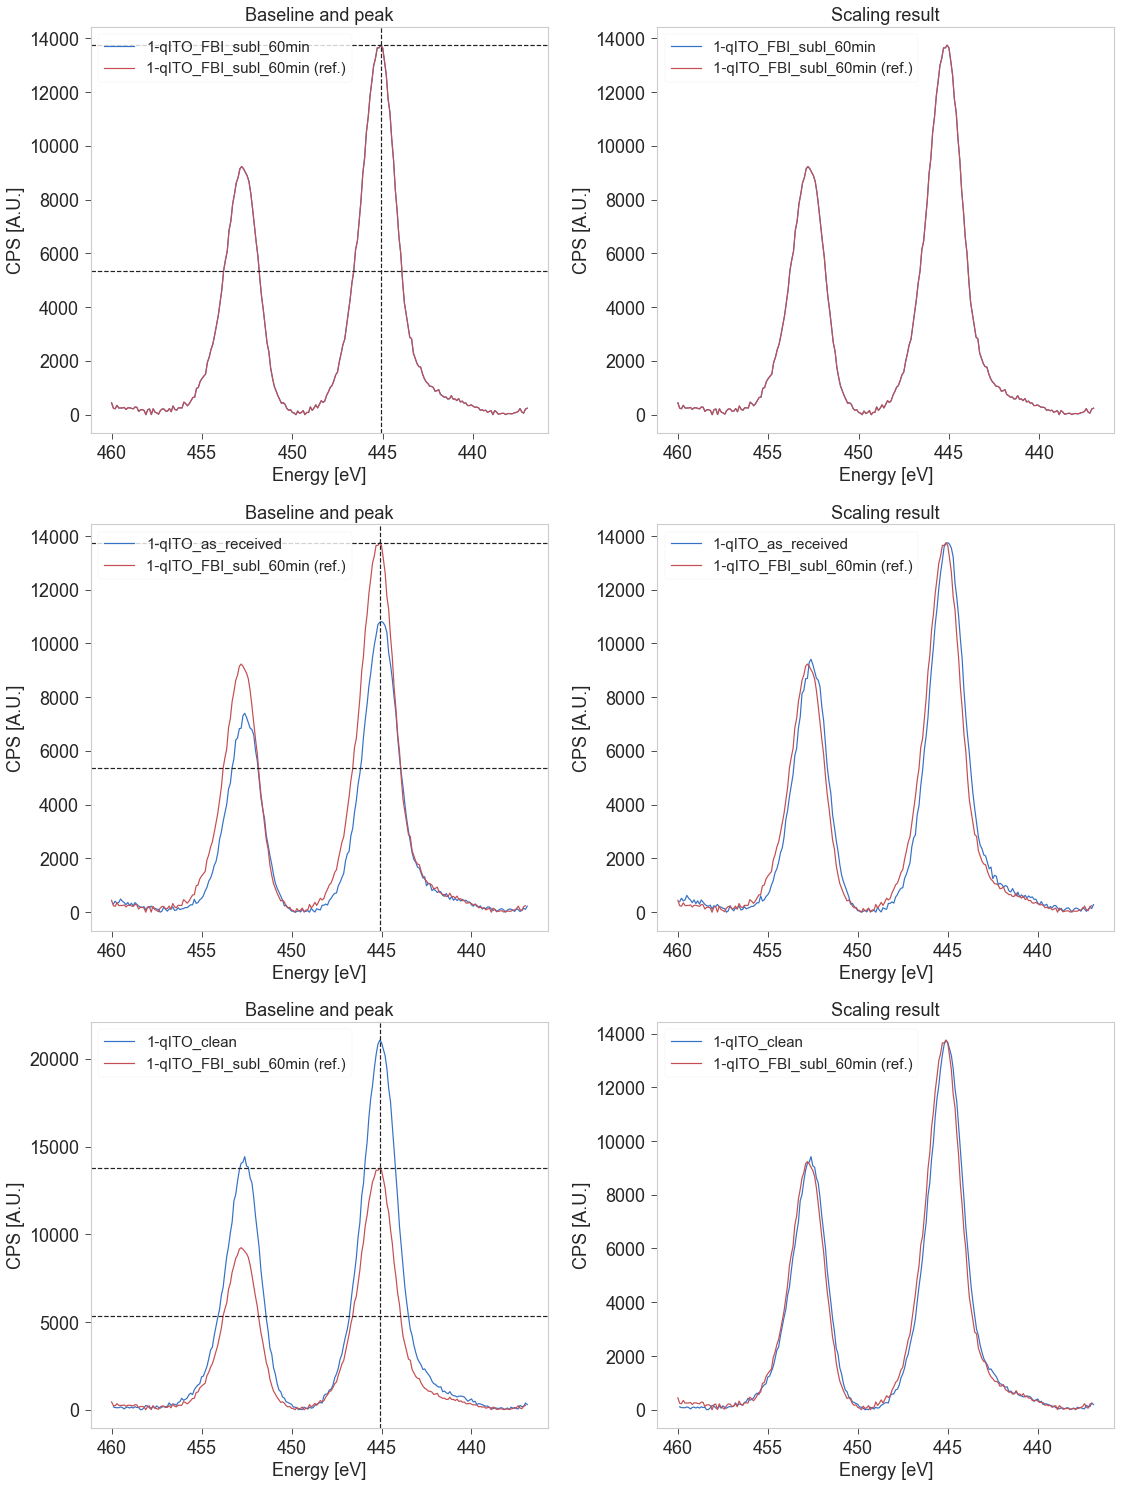

In [28]:
scaled_exps = scale_and_plot_spectra(bg_exps, indRef=0, region='In3d')

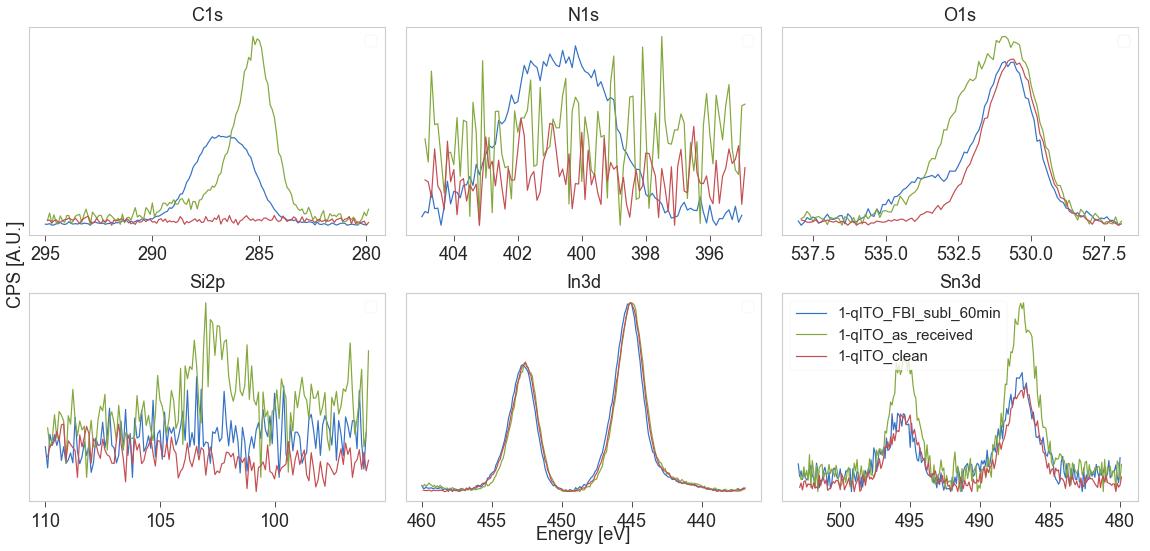

In [29]:
regions = ['C1s', 'N1s', 'O1s', 'Si2p', 'In3d', 'Sn3d']
plot_xp_regions(scaled_exps, regions, ncols=3);

# Store processed experiments

In [30]:
def store_results(bg_exps: list, scaled_exps: list):

    for xpu, xps in zip(bg_exps, scaled_exps):
        filepath, filename = os.path.split(xpu.path)
        filename = os.path.splitext(filename)[0]
        newpath = filepath + '/proc/'
        try:
            os.mkdir(newpath)
        except FileExistsError: pass
        print('Stored ', newpath + filename)
        write_processed_xp(newpath + filename + '.uxy', xpu)
        write_processed_xp(newpath + filename + '.sxy', xps)

In [31]:
store_results(bg_exps, scaled_exps)

Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_15_qITO/proc/20210415_1-qITO_FBI_subl_60min
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_15_qITO/proc/20210415_1-qITO_as_received
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_15_qITO/proc/20210415_1-qITO_clean
